# install moabb & braindecode

In [ ]:
pip install moabb

In [ ]:
pip install braindecode

In [ ]:
pip install -U https://api.github.com/repos/shivar2/braindecode/zipball/master

# connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os, sys
os.chdir('/content/drive/MyDrive/MotorImagery-Classification')

# subject

In [ ]:
subject_id = 1

# load data

In [ ]:
import torch

dataset = torch.load('data-file/Schirrmeister2017/' + str(subject_id) + '.pt')

# Cut Compute Windows

for trials


In [ ]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)


# Split dataset into train and valid

In [ ]:
splitted = windows_dataset.split('run')
train_set = splitted['train']
valid_set = splitted['test']

# Create model

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()


# Training

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

batch_size = 64
n_epochs = 10

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)



  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.8094        1.1129            0.4375        1.2476  0.0006  2.8780
      2            0.8531        0.7976            0.4375        1.3691  0.0006  2.7142
      3            0.8969        0.6686            0.4500        1.3877  0.0006  2.7315
      4            0.9281        0.5041            0.4750        1.2863  0.0005  2.7539
      5            0.9750        0.3779            0.4938        1.1711  0.0004  2.7541
      6            0.9875        0.3081            0.5250        1.1174  0.0003  2.7729
      7            0.9938        0.2891            0.5250        1.1000  0.0002  2.7301
      8            0.9938        0.2654            0.5312        1.0949  0.0001  2.7826
      9            0.9938        0.2553            0.5312        1.0962  0.0000  2.7849
     10            0.9969       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 128), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 4, kernel_size=(144, 1), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

# Plot Results

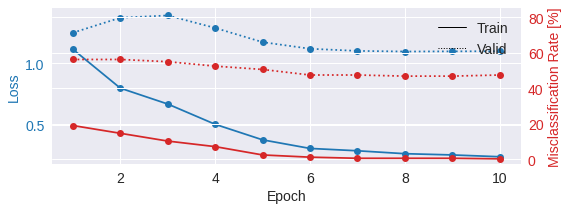

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()
